# Zero-shot Image Classification with OpenAI CLIP and OpenVINO™

Zero-shot image classification is a computer vision task to classify images into one of several classes without any prior training or knowledge of the classes.

![zero-shot-pipeline](https://user-images.githubusercontent.com/29454499/207773481-d77cacf8-6cdc-4765-a31b-a1669476d620.png)

[**image source*](https://huggingface.co/tasks/zero-shot-image-classification)


Zero-shot learning resolves several challenges in image retrieval systems. For example, with the rapid growth of categories on the web, it is challenging to index images based on unseen categories. We can associate unseen categories to images with zero-shot learning by exploiting attributes to model's relationship between visual features and labels.
In this tutorial, we will use the [OpenAI CLIP](https://github.com/openai/CLIP) model to perform zero-shot image classification. Additionally, the notebook demonstrates how to optimize the model using [NNCF](https://github.com/openvinotoolkit/nncf/).

The notebook contains the following steps:

1. Download the model.
2. Instantiate the PyTorch model.
3. Convert model to OpenVINO IR, using the model conversion API.
4. Run CLIP with OpenVINO.
5. Quantize the converted model with NNCF.
6. Check the quantized model inference result.
7. Compare model size of converted and quantized models.
8. Compare performance of converted and quantized models.
9. Launch interactive demo





#### Table of contents:

- [Instantiate model](#Instantiate-model)
- [Run PyTorch model inference](#Run-PyTorch-model-inference)
- [Convert model to OpenVINO Intermediate Representation (IR) format.](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR)-format.)
- [Run OpenVINO model](#Run-OpenVINO-model)
    - [Select inference device](#Select-inference-device)
- [Quantize model to INT8 using NNCF](#Quantize-model-to-INT8-using-NNCF)
    - [Prepare datasets](#Prepare-datasets)
    - [Perform quantization](#Perform-quantization)
    - [Run quantized OpenVINO model](#Run-quantized-OpenVINO-model)
    - [Compare File Size](#Compare-File-Size)
    - [Compare inference time of the FP16 IR and quantized models](#Compare-inference-time-of-the-FP16-IR-and-quantized-models)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/clip-zero-shot-image-classification/clip-zero-shot-classification.ipynb" />


## Instantiate model
[back to top ⬆️](#Table-of-contents:)

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.
CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score.

![clip](https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png)

[**image_source*](https://github.com/openai/CLIP/blob/main/README.md)

You can find more information about this model in the [research paper](https://arxiv.org/abs/2103.00020), [OpenAI blog](https://openai.com/blog/clip/), [model card](https://github.com/openai/CLIP/blob/main/model-card.md) and GitHub [repository](https://github.com/openai/CLIP).

In this notebook, we will use [openai/clip-vit-base-patch16](https://huggingface.co/openai/clip-vit-base-patch16), available via Hugging Face Transformers, but the same steps are applicable for other CLIP family models.

First, we need to create `CLIPModel` class object and initialize it with model configuration and weights, using `from_pretrained` method. The model will be automatically downloaded from Hugging Face Hub and cached for the next usage.
`CLIPProcessor` class is a wrapper for input data preprocessing. It includes both encoding the text using tokenizer and preparing the images.

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "gradio>=4.19" "matplotlib>=3.4" "openvino>=2023.1.0" "transformers[torch]>=4.30" "datasets" "nncf>=2.6.0" "torch>=2.1" Pillow

import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# load pre-trained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [3]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(image: Image, labels: List[str], probs: np.ndarray, top: int = 5):
    """
    Utility function for visualization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visualization
    returns:
      None
    """
    plt.figure(figsize=(64, 64))
    top_labels = np.argsort(-probs)[: min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    plt.subplot(8, 8, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 8, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels])
    plt.xlabel("probability")

## Run PyTorch model inference
[back to top ⬆️](#Table-of-contents:)

To perform classification, define labels and load an image in RGB format. To give the model wider text context and improve guidance, we extend the labels description using the template "This is a photo of a".
Both the list of label descriptions and image should be passed through the processor to obtain a dictionary with input data in the model-specific format. The model predicts an image-text similarity score in raw logits format, which can be normalized to the `[0, 1]` range using the `softmax` function. Then, we select labels with the highest similarity score for the final result.

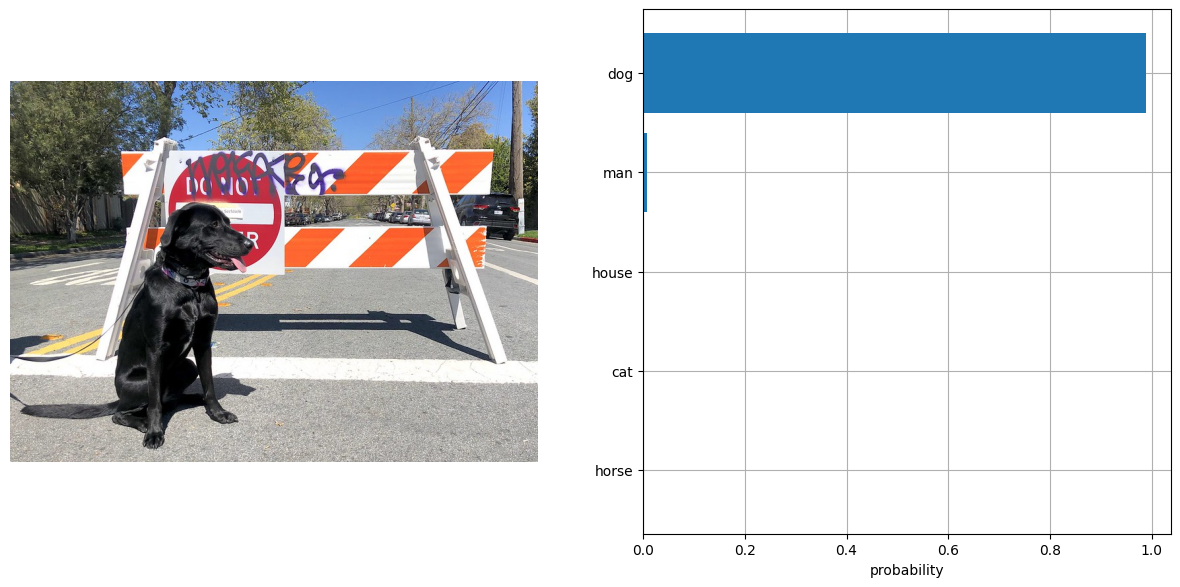

In [4]:
import requests
from pathlib import Path


sample_path = Path("data/coco.jpg")
sample_path.parent.mkdir(parents=True, exist_ok=True)
r = requests.get("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg")

with sample_path.open("wb") as f:
    f.write(r.content)

image = Image.open(sample_path)

input_labels = [
    "cat",
    "dog",
    "wolf",
    "tiger",
    "man",
    "horse",
    "frog",
    "tree",
    "house",
    "computer",
]
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results["logits_per_image"]  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach().numpy()  # we can take the softmax to get the label probabilities
visualize_result(image, input_labels, probs[0])

## Convert model to OpenVINO Intermediate Representation (IR) format.
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions. We can save it on disk for the next usage with `ov.save_model`.


In [5]:
import openvino as ov

fp16_model_path = Path("clip-vit-base-patch16.xml")
model.config.torchscript = True

if not fp16_model_path.exists():
    ov_model = ov.convert_model(model, example_input=dict(inputs))
    ov.save_model(ov_model, fp16_model_path)

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

The steps for making predictions with the OpenVINO CLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the example above with PyTorch.

In [6]:
from scipy.special import softmax

# create OpenVINO core object instance
core = ov.Core()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [7]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

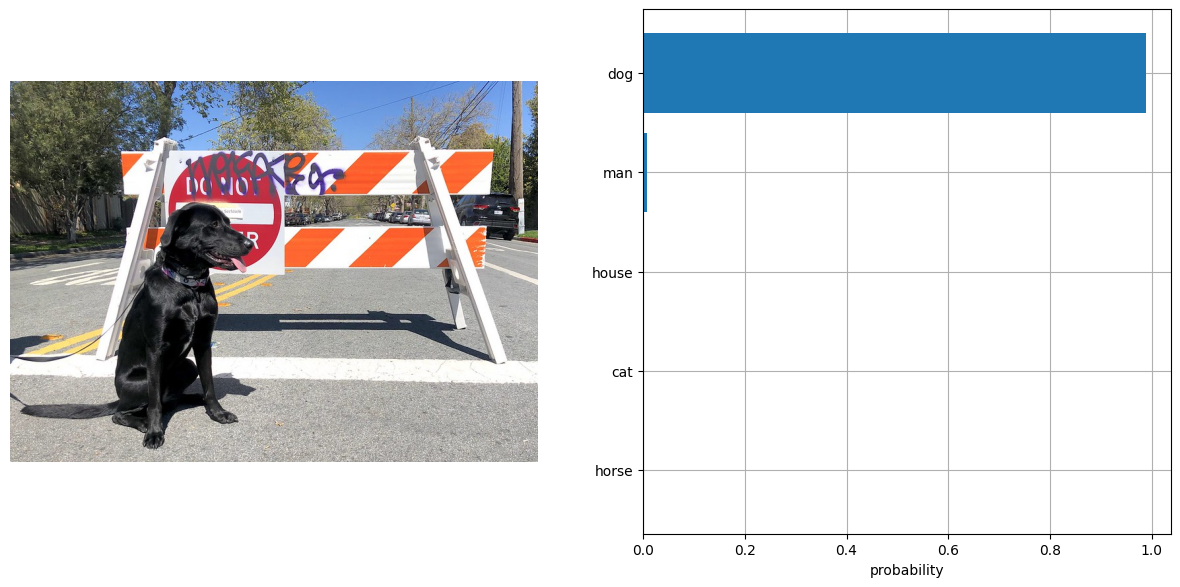

In [8]:
# compile model for loading on device
compiled_model = core.compile_model(fp16_model_path, device.value)
# run inference on preprocessed data and get image-text similarity score
ov_logits_per_image = compiled_model(dict(inputs))[0]
# perform softmax on score
probs = softmax(ov_logits_per_image, axis=1)
# visualize prediction
visualize_result(image, input_labels, probs[0])

Great! Looks like we got the same result.

## Quantize model to INT8 using NNCF
[back to top ⬆️](#Table-of-contents:)

The goal of this part of tutorial is to demonstrate how to speed up the model by applying 8-bit post-training quantization from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) and infer quantized model via OpenVINO™ Toolkit. 
[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.
The optimization process contains the following steps:

1. Prepare quantization dataset
2. Quantize the converted OpenVINO model with NNCF.
3. Check the model result using the same input data like we use.
4. Compare model size of converted and quantized models.
5. Compare performance of converted and quantized models.

> **Note:** quantization process may require additional time and memory for performing. You can disable it using widget below:

In [9]:
from notebook_utils import quantization_widget

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [10]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### Prepare datasets
[back to top ⬆️](#Table-of-contents:)

The [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset consisting of ~3.3M images annotated with captions is used to quantize model.

In [11]:
%%skip not $to_quantize.value

import requests
from io import BytesIO
import numpy as np
from PIL import Image
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

max_length = model.config.text_config.max_position_embeddings

def check_text_data(data):
    """
    Check if the given data is text-based.
    """
    if isinstance(data, str):
        return True
    if isinstance(data, list):
        return all(isinstance(x, str) for x in data)
    return False

def get_pil_from_url(url):
    """
    Downloads and converts an image from a URL to a PIL Image object.
    """
    response = requests.get(url, verify=False, timeout=20)
    image = Image.open(BytesIO(response.content))
    return image.convert("RGB")

def collate_fn(example, image_column="image_url", text_column="caption"):
    """
    Preprocesses an example by loading and transforming image and text data.
    Checks if the text data in the example is valid by calling the `check_text_data` function.
    Downloads the image specified by the URL in the image_column by calling the `get_pil_from_url` function.
    If there is any error during the download process, returns None.
    Returns the preprocessed inputs with transformed image and text data.
    """
    assert len(example) == 1
    example = example[0]

    if not check_text_data(example[text_column]):
        raise ValueError("Text data is not valid")

    url = example[image_column]
    try:
        image = get_pil_from_url(url)
        h, w = image.size
        if h == 1 or w == 1:
            return None
    except Exception:
        return None

    inputs = processor(text=example[text_column], images=[image], return_tensors="pt", padding=True)
    if inputs['input_ids'].shape[1] > max_length:
        return None
    return inputs

In [12]:
%%skip not $to_quantize.value

import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

def prepare_calibration_data(dataloader, init_steps):
    """
    This function prepares calibration data from a dataloader for a specified number of initialization steps.
    It iterates over the dataloader, fetching batches and storing the relevant data.
    """
    data = []
    print(f"Fetching {init_steps} samples for the initialization...")
    with tqdm(total=init_steps) as pbar:
        for batch in dataloader:
            if len(data) == init_steps:
                break
            if batch:
                pbar.update(1)
                with torch.no_grad():
                    data.append(
                        {
                            "pixel_values": batch["pixel_values"].to("cpu"),
                            "input_ids": batch["input_ids"].to("cpu"),
                            "attention_mask": batch["attention_mask"].to("cpu")
                        }
                    )
    return data


def prepare_dataset(opt_init_steps=50, max_train_samples=1000):
    """
    Prepares a vision-text dataset for quantization.
    """
    dataset = load_dataset("google-research-datasets/conceptual_captions", trust_remote_code=True)
    train_dataset = dataset["train"].shuffle(seed=42)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)
    calibration_data = prepare_calibration_data(dataloader, opt_init_steps)
    return calibration_data

In [13]:
%%skip not $to_quantize.value

import logging
import nncf

core = ov.Core()

nncf.set_log_level(logging.ERROR)

int8_model_path = 'clip-vit-base-patch16_int8.xml'
calibration_data = prepare_dataset()
ov_model = core.read_model(fp16_model_path)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/datasets/load.py:1429: FutureWarning: The repository for conceptual_captions contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conceptual_captions
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Fetching 50 samples for the initialization...


  0%|          | 0/50 [00:00<?, ?it/s]

### Perform quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained `FP16` model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

In [14]:
%%skip not $to_quantize.value

if len(calibration_data) == 0:
    raise RuntimeError(
        'Calibration dataset is empty. Please check internet connection and try to download images manually.'
    )

calibration_dataset = nncf.Dataset(calibration_data)
quantized_model = nncf.quantize(
    model=ov_model,
    calibration_dataset=calibration_dataset,
    model_type=nncf.ModelType.TRANSFORMER,
    # Smooth Quant algorithm reduces activation quantization error; optimal alpha value was obtained through grid search
    advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alpha=0.6)
)
ov.save_model(quantized_model, int8_model_path)

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/nncf/quantization/algorithms/post_training/pipeline.py:87: FutureWarning: `AdvancedQuantizationParameters(smooth_quant_alpha=..)` is deprecated.Please, use `AdvancedQuantizationParameters(smooth_quant_alphas)` option with AdvancedSmoothQuantParameters(convolution=.., matmul=..) as value instead.
  warning_deprecated(


Output()

Output()

Output()

Output()

### Run quantized OpenVINO model
[back to top ⬆️](#Table-of-contents:)

The steps for making predictions with the quantized OpenVINO CLIP model are similar to the PyTorch model. Let us check the model result using the same input data that we used before.

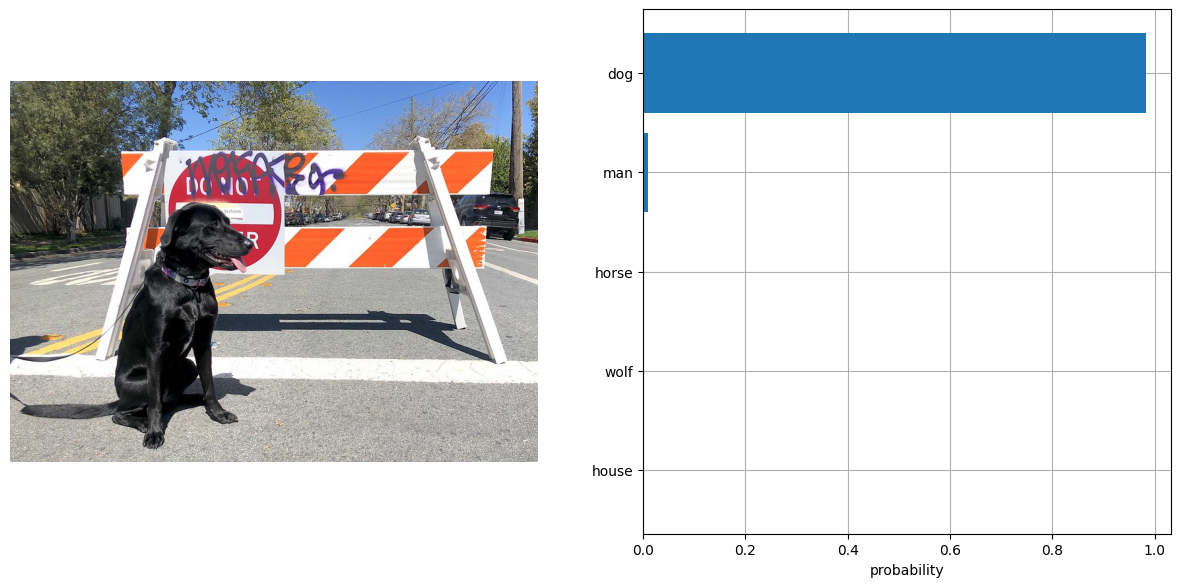

In [15]:
%%skip not $to_quantize.value

# compile model for loading on device
compiled_model = core.compile_model(quantized_model, device.value)
# run inference on preprocessed data and get image-text similarity score
ov_logits_per_image = compiled_model(dict(inputs))[0]
# perform softmax on score
probs = softmax(ov_logits_per_image, axis=1)
# visualize prediction
visualize_result(image, input_labels, probs[0])

Nice! Results looks similar to fp16 model results before quantization.

### Compare File Size
[back to top ⬆️](#Table-of-contents:)

In [17]:
%%skip not $to_quantize.value

from pathlib import Path

fp16_ir_model_size = Path(fp16_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024 / 1024
print(f"FP16 IR model size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 model size: {quantized_model_size:.2f} MB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 IR model size: 285.38 MB
INT8 model size: 143.60 MB
Model compression rate: 1.987


### Compare inference time of the FP16 IR and quantized models
[back to top ⬆️](#Table-of-contents:)
To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.


> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [20]:
%%skip not $to_quantize.value

import time

def calculate_inference_time(model_path, calibration_data):
    model = core.compile_model(model_path, device.value)
    inference_time = []
    for batch in calibration_data:
        start = time.perf_counter()
        _ = model(batch)[0]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [21]:
%%skip not $to_quantize.value

fp16_latency = calculate_inference_time(fp16_model_path, calibration_data)
int8_latency = calculate_inference_time(int8_model_path, calibration_data)
print(f"Performance speed up: {fp16_latency / int8_latency:.3f}")

Performance speed up: 1.639


## Interactive demo
[back to top ⬆️](#Table-of-contents:)
## Interactive demo

Now, it is your turn! You can provide your own image and comma-separated list of labels for zero-shot classification.

Feel free to upload an image, using the file upload window and type label names into the text field, using comma as the separator (for example, `cat,dog,bird`)

In [ ]:
model_path = Path("clip-vit-base-patch16-int8.xml")
if not model_path.exists():
    model_path = Path("clip-vit-base-patch16.xml")
compiled_model = core.compile_model(model_path, device.value)


def classify(image, text):
    """Classify image using classes listing.
    Args:
        image (np.ndarray): image that needs to be classified in CHW format.
        text (str): comma-separated list of class labels
    Returns:
        (dict): Mapping between class labels and class probabilities.
    """
    labels = text.split(",")
    text_descriptions = [f"This is a photo of a {label}" for label in labels]
    inputs = processor(text=text_descriptions, images=[image], return_tensors="np", padding=True)
    ov_logits_per_image = compiled_model(dict(inputs))[0]
    probs = softmax(ov_logits_per_image, axis=1)[0]

    return {label: float(prob) for label, prob in zip(labels, probs)}

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/clip-zero-shot-image-classification/gradio_helper.py"
    )
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(classify)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/